# Initiation

In [75]:
# To manipulate arrays
import numpy as np 

# To handle track DataFrames
import pandas as pd

# For working with x-arrays
import xarray as xr

# To import images
from skimage import io 
from skimage.io import imread

# For TrackPy
import trackpy as tp

# To make plots
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()  

# To work inline; change to %matplotlib notebook for interactive plotting
%matplotlib inline 

# Napari 
%gui qt5 
from skimage import data
import napari

# Image processing and filters
from skimage.filters import difference_of_gaussians

# For directories 
import os
from pathlib import Path, PureWindowsPath # for working with windows paths

# For reloading a library when testing
import importlib

# For deleting/reloading modules in another file for code testing
import sys

# Import trackArrayTools
cwd = os.getcwd()
os.chdir("../croparray")
import crop_array_tools as ca
os.chdir(cwd)


plt.style.use('dark_background')

# Create Crop Array

To do: 
1. I should probably make a unique id layer (maybe uid), so I can use groupby and map to map arbitrary functions to individual crops.

In [86]:
# Enter in the following:
video_3D_directory = r'../database'
video_3D_filename = r'Hela_confocal.tif'        
csv_filename = r'Crops_Hela_confocal.csv'

In [87]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video_3D = np.array([imread(os.path.join(video_3D_directory,video_3D_filename))])
video_3D.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)

(1, 33, 7, 472, 312, 3)

In [88]:
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join(video_3D_directory, csv_filename)) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'POSITION_X': 'xc','POSITION_Y': 'yc', 'FRAME': 'f','TRACK_ID':'id'}, inplace=True, errors='raise')
 # Here we need to create an fov column since there was only 1 fov with the sample dataset. Can give it a name, but note that in the crop array it will be assigned a unique fov integer number starting from 0
spots['fov']=video_3D_filename  
# can include other optional columns for making layers, like 'ID', and 'MEAN_INTENSITY'
spots = spots[['fov','id','f','yc','xc','ID','MEAN_INTENSITY']]  
spots.head()

,fov,id,f,yc,xc,ID,MEAN_INTENSITY
0,Hela_confocal.tif,0,0,14.0,69.0,10777,1097.358
1,Hela_confocal.tif,0,1,13.0,69.0,11306,1135.689
2,Hela_confocal.tif,0,2,14.0,69.0,11135,1129.935
3,Hela_confocal.tif,0,3,14.0,69.0,10954,1129.091
4,Hela_confocal.tif,0,4,13.0,70.0,11466,1120.109


In [ ]:
# create crop array using minimal arguments
my_ca = ca.create_crop_array(video_3D, spots)
my_ca

In [ ]:
# create crop array with all key word arguments. This is recommended to keep track of all information for later databasing
temp_name = video_3D_directory+'/'+video_3D_filename
my_ca = ca.create_crop_array(video_3D, spots, dx=130, dy=130, dz=500, dt=1, units=['nm','s'], name=temp_name, date='2021-12-25')
my_ca.attrs['notes'] = 'A crop array with ch0 = MYH9 mRNA, ch1 = nascent myo2A peptide signal (anti-FLAG Fab + smFLAG), ch3 = mature protein GFP-myo2A. mRNA spots were tracked using TrackMate.'
my_ca

# Best-Z projection

The goal here is to implement a best-z projection function using the full functionality of x-array.

In [ ]:
def best_z_proj(ca, **kwargs):
    '''
    Returns an x-array that holds the best-z projection of intensities of spots in a reference channel.

    Parameters
    ----------
    ca: crop arrray (x-array dataset)
        A crop array.
    ref_ch: int, optional 
        A reference intensity channel for finding the best-z projection. Default: ref_ch = 0
    disk_r: int, optional
        The radius of the disk (in pixels) to make measurements to determine the best-z slice. Default: disk_r = 2
    roll_num: int, optional
        The number of z-slices to use in the rolling-z max projection for determining the best-z slice. min_periods in the da.rolling() function is set to 1 so there will be no Nans at the z-edges of crops. Default: roll_num = 1.

    Returns
    ------- 
    A 'best-z' x-array with dimensions (fov,n,t,y,x,ch). The best-z x-array contains the intensities of each crop in the 'best' z-slice, where 'best' is defined as the slice having the maximal intensity within a centered xy disk of radius disk_r pixels. A rolling-z maximum projection (over roll_n z-slices) can optionally be performed so best-z represents a max-z projection across multiple z-slices.
    
    '''
    # Get the optional key word arguments (kwargs):
    ref_ch = kwargs.get('ref_ch', 0)
    disk_r = kwargs.get('disk_r', 2) 
    roll_n = kwargs.get('roll_n', 1)

    res = ca.dx # resolution for defining disk to make measurements to determine best-z

    # Get z-signals in disk within each z-plane and apply rolling z-average of these signals
    z_sig = ca.sel(ch=ref_ch).int.where(lambda a: a.x**2 + a.y**2 <= (disk_r*res)**2).mean(dim=['x','y']).rolling(z=roll_n, center=True, min_periods=1).max()

    # Choose z-plane in ca.int corresponding to max z-signal for each channel, then concatenate x-arrays with coordinate channels
    return xr.concat([ca.int.sel(ch=i).rolling(z=roll_n,center=True,min_periods=1).max().isel(z_sig.argmax(dim=['z'])) for i in ca.ch], dim='ch')
    

In [ ]:
my_ca['best_z']=best_z
my_ca

In [ ]:
np.unique(my_ca.id)

In [ ]:
# Plot one of the crops over time to test
best_z = best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
best_z.where(my_ca.id==25).mean('n').sel(fov=0).plot.imshow(col='t',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5)

# Background subtraction

In [ ]:
best_z = best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)
bg = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2))
bg.sel(fov=0,t=slice(0,3),n=slice(0,1)).plot.imshow(col='t',row='n',rgb='ch',yticks=[],xticks=[],robust=True,size=2)

In [ ]:
donut_sig = bg.mean(dim=['x','y'])
best_z - donut_sig

# Disk-donut intensity quantification

The following code does disk-donut quantification on the best-z slices to measure signal intensities. Need to implement this i|nto a function.

In [ ]:
# Create best-z projection (if not already)
best_z = best_z_proj(my_ca, ref_ch=0, disk_r=3, roll_n=3)

# disk has radius of 3 pixels:
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
# donut has width 1 pixel with inner radius of 5 pixels:
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
signal = disk_sig - donut_sig 
best_z_bg = best_z -donut_sig
my_ca['signal'] = signal
my_ca

Now that we have a signal, we can analyze the mRNA intensity data easily: 

In [ ]:
my_ca.signal.where(my_ca.signal>0).sel(ch=0).plot.hist(bins=40, range=(-20,20));

In [ ]:
my_ca.where(my_ca.signal>0).plot.scatter(x='signal',y='MEAN_INTENSITY',col='ch',hue='ch',colors=['red','limegreen','blue'],levels=[0,1,2,3])

# Sorting crop ids by average translation signal intensity through time

In [ ]:
# Create best-z projection (if not already)
best_z = best_z_proj(my_ca, ref_ch=0, disk_r=2, roll_n=3)

# Make a background subtracted x-array for plotting on same scale
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])
best_z_bg = best_z -donut_sig

# Now sort based on signal average over time with disk-donut intensity
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])
signal = disk_sig - donut_sig
my_ca['signal'] = signal
my_ca['signal'].attrs['notes']='Disk donut on best_z_bg w/ ref_ch=0, disk_r=4, roll_n=3, donut_r = 5-6'

In [ ]:
# Visualize the sorted spots t = 0
ca_sort = best_z_bg.sel(t=0).sortby(my_ca.signal.sel(t=0,ch=1,fov=0),ascending=False)
ca_sort.sel(fov=0).plot.imshow(col='n',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5,vmin=0,vmax=30)

In [ ]:
# If ids correspond to tracks, we can also visualize tracks through time  
my_id = np.unique(my_ca.id) # Find all unique ids

# We create a dataset with 'id' as a coordinate in this case
track_sig = xr.concat([my_ca.signal.where(my_ca.id == i).mean(['n']) for i in my_id],dim=pd.Index(my_id, name='id')).to_dataset()

# This allows us to focus on specific tracks in plots:
sns.set_palette(['red','limegreen','blue'])
track_sig.sel(id=101,fov=0).signal.plot.line(x='t',hue='ch')

In [ ]:
# Now we sort the trck ids by the mean intensity of each track through time 
# We can look for tracks with bright translation signals, but dim mature protein signals 
# For this, we sort by translation signal - mature protein signal (or could do any variant)
sorted = track_sig.sortby(track_sig.signal.sel(fov=0,ch=1).mean('t'),ascending=False)
sorted_ids = sorted.id.values.astype(int)
sorted_ids

In [ ]:
# To visualize the time-averaged tracks all sorted, we create a crop array and plot it 
sorted_xr = xr.concat([best_z_bg.where(my_ca.id==i, drop=True).mean(dim=['n']) for i in sorted_ids], dim=pd.Index(sorted_ids, name='id'))


In [ ]:
sorted_xr.sel(fov=0).mean('t').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

In [ ]:
# If you just want to see the first 20:
sorted_xr.isel(fov=0,id=slice(0,20)).mean('y').plot.imshow(col='id',rgb='ch',col_wrap=10,robust=True,xticks=[],yticks=[],size=1.5, vmin=0, vmax=30)

In [ ]:
# Now that we've organized things by id (track), we can easily normalize track data
start_sig = track_sig.sel(t=slice(0,0)).mean('t')
end_sig = track_sig.sel(t=slice(30,33)).mean('t')
norm_sig = (track_sig - end_sig)/(start_sig - end_sig)
sns.set_palette(['red','limegreen','blue'])
norm_sig.sel(id=10,fov=0).signal.plot.line(x='t',hue='ch')


In [ ]:
sns.set_palette(['cyan'])
my_data = norm_sig.signal.sel(fov=0,ch=2).to_pandas()
g=sns.relplot(x='t', y='RNA Intensity (a.u.)',data=pd.melt(my_data,value_name="RNA Intensity (a.u.)").dropna(),kind='line',height=3,aspect=5)


In [ ]:
donut_sanity_check = best_z_bg.where(lambda x: (x.x**2 + x.y**2 >= (my_ca.dx*5)**2) & (x.x**2 + x.y**2 < (my_ca.dx*6)**2)).mean(dim=['x','y'])

In [ ]:
sns.set_palette(['red'])
donut_sanity_check.sel(fov=0,ch=0,n=slice(0,5)).plot(col='n',hue='ch',col_wrap=6)

# Writing and reading crop arrays using netcdf file format

In [ ]:
my_ca.to_netcdf('my_crop_array.nc')

In [ ]:
test = xr.open_dataset("my_crop_array.nc")
test

# Testing O'Neil's dataset

In [238]:
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join('../database/Data From ONeil', r'cell_nucID_Spot_Intensity_DonutBkg_0_211110233709.csv')) 
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'image':'fov', 'Y': 'yc','X': 'xc'}, inplace=True, errors='raise')
spots['f']=0
spots['id']=spots.index
# Carry through some of the important columns for the crop array
spots=spots[['fov','id','f','yc','xc','MeanSub','cellid','nucid','cytoid']]
spots.head()

,fov,id,f,yc,xc,MeanSub,cellid,nucid,cytoid
0,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,0,0,15.0,555.0,0.0,1,1,0
1,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,1,0,15.0,555.0,0.0,1,1,0
2,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,2,0,15.0,555.0,3935.9,1,1,0
3,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,3,0,15.0,555.0,268.7,1,1,0
4,052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x...,4,0,18.5,203.0,61.8,3,0,1


In [237]:
# Read in csv; note minimal need columns to be used for fov = field of view, f = frame, id = crop/track id #, yc = y-center position of crop, xc - x-center position of crop
spots = pd.read_csv(os.path.join('../database/Data From ONeil', r'Segmented_Centroids_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x_ - 1_c561_211110225854.csv')) 
spots2 = pd.read_csv(os.path.join('../database/Data From ONeil', r'Segmented_Centroids_052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_100x_ - 1_c561_211110225854.csv')) 
spots=pd.concat([spots1, spots2]).reset_index(drop=True)
spots['id']=spots.index
# Rename the Trackmate columns to crop array standards of fov, f, id, yc, and xc
spots.rename(columns={'Label':'fov', 'Y': 'yc','X': 'xc'}, inplace=True, errors='raise')
spots['f']=0
spots

,,fov,Area,Mean,xc,yc,id,f
0,1,MAX_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_...,4,41450.2,555.0,15.0,0,0
1,2,MAX_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_...,2,37682.5,203.0,18.5,1,0
2,3,MAX_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_...,1,51772.0,255.5,18.5,2,0
3,4,MAX_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_...,8,36207.6,186.4,25.4,3,0
4,5,MAX_052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_...,1,39321.0,327.5,26.5,4,0
...,...,...,...,...,...,...,...,...
656,176,MAX_052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_...,1,33422.0,219.5,882.5,656,0
657,177,MAX_052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_...,2,38337.5,588.0,894.5,657,0
658,178,MAX_052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_...,4,50297.5,49.0,907.0,658,0
659,179,MAX_052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_...,2,49151.0,37.0,910.5,659,0


In [239]:
# Read in video; note I added an fov dimension using np.array since this is only 1 fov
video_1 = np.array([imread(os.path.join('../database/Data From ONeil','052121_Hela_CBS_C+A_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640.tiff'))])
video_2 = np.array([imread(os.path.join('../database/Data From ONeil','052121_Hela_CBS_GL2_48h_Flag TR_MCP JF646_100x_ - 1_c405_c488_c561_c640.tiff'))])
video_2.shape # dimensions MUST be (fov, f = frame, z, y, x, ch)
video=np.array([video_1[:,0:18],video_2])
# fov, f, z, y, x, ch  --> fov, f, z, y, x, ch
video.shape

(2, 1, 18, 928, 624, 4)

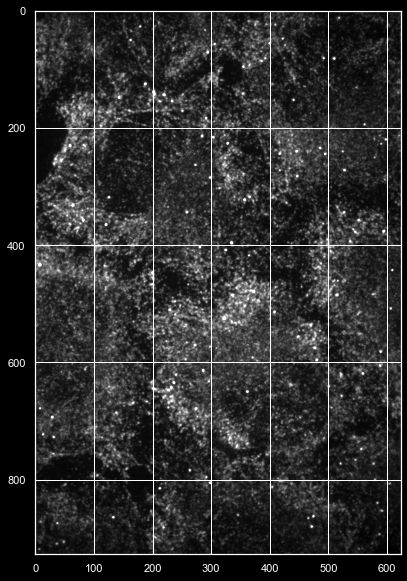

In [211]:
# Just examining one of the images
f = plt.figure(figsize=(10,10))
myimg=np.max(video_2.squeeze(),axis=0)[:,:,2]
plt.imshow(myimg,cmap='gray',vmin=1000, vmax=20000)

In [240]:
my_ca = ca.create_crop_array(video,spots,xy_pad=5)
my_ca

Original video dimensions:  (2, 1, 18, 928, 624, 4)
Padded video dimensions:  (2, 1, 18, 940, 636, 4)
Max # of spots per frame:  1924
Shape of numpy array to hold all crop intensity data:  (2, 1924, 1, 18, 11, 11, 4)
Shape of xc and yc numpy arrays:  (2, 1924, 1, 4)
Shape of extra my_layers numpy array:  (5, 2, 1924, 1)


<xarray.Dataset>
Dimensions:  (fov: 2, n: 1924, t: 1, z: 18, y: 11, x: 11, ch: 4)
Coordinates:
  * fov      (fov) int32 0 1
  * n        (n) int32 0 1 2 3 4 5 6 7 ... 1917 1918 1919 1920 1921 1922 1923
  * t        (t) int32 0
  * z        (z) int32 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17
  * y        (y) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * x        (x) int32 -5 -4 -3 -2 -1 0 1 2 3 4 5
  * ch       (ch) int32 0 1 2 3
Data variables:
    int      (fov, n, t, z, y, x, ch) int32 787 1594 1184 1171 1912 ... 0 0 0 0
    xc       (fov, n, t, ch) int32 561 561 561 561 561 561 561 ... 0 0 0 0 0 0 0
    yc       (fov, n, t, ch) int32 21 21 21 21 21 21 21 21 ... 0 0 0 0 0 0 0 0
    dx       int32 1
    dy       int32 1
    dz       int32 1
    dt       int32 1
    id       (fov, n, t) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 0.0 0.0 0.0 0.0 0.0
    MeanSub  (fov, n, t) float64 0.0 0.0 3.936e+03 269.0 ... 0.0 0.0 0.0 0.0
    cellid   (fov, n, t) float64 1.0 1.0 1.0 1.0 3.0 3.0 ... 0.0 0.0 0.0 0.0 0.0
    nucid    (fov, n, t) float64 1.0 1.0 1.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    cytoid   (fov, n, t) float64 0.0 0.0 0.0 0.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    units:    ['space', 'time']
    name:     video_filename
    date:     video_date

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


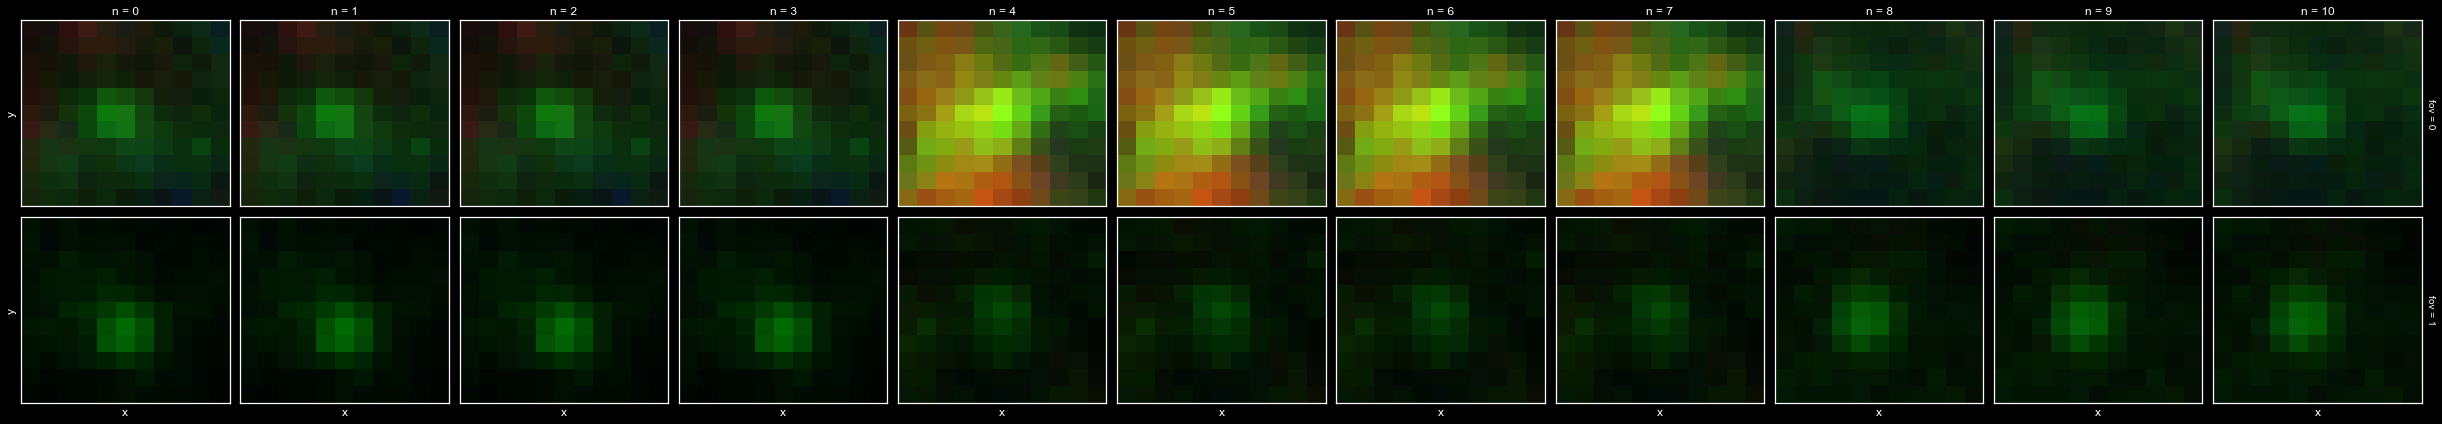

In [241]:
# Check the first 10 spots (max-z projected) of each fov to make sure things are centered. 
# Choosing ch = 1, 2 (translation), and 3 for rgb mapping
my_ca.int.sel(ch=[1,2,3],n=slice(0,10)).mean(dim=['t']).max('z').plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[])

In [248]:
# Create best-z projection using channel 2 (translation) as a reference. taking bestz +/- 1 here (roll_n = 3)
best_z = best_z_proj(my_ca, ref_ch=2, disk_r=3, roll_n=3)

# measure intensity in disk with radius of 3 pixels:
disk_sig = best_z.where(lambda a: a.x**2 + a.y**2 <= (3*my_ca.dx)**2).mean(dim=['x','y'])

# measure intensity in donut with width 1 pixel and inner radius of 5 pixels:
donut_sig = best_z.where(lambda a: (a.x**2 + a.y**2 >= (5*my_ca.dx)**2) & (a.x**2 + a.y**2 < (6*my_ca.dx)**2)).mean(dim=['x','y'])

# disk-donut intensity quantification
signal = disk_sig - donut_sig 

# create a best-z projection that is background subtracted
best_z_bg = best_z -donut_sig

# add signal layer to original crop array for sorting and things
my_ca['signal'] = signal

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


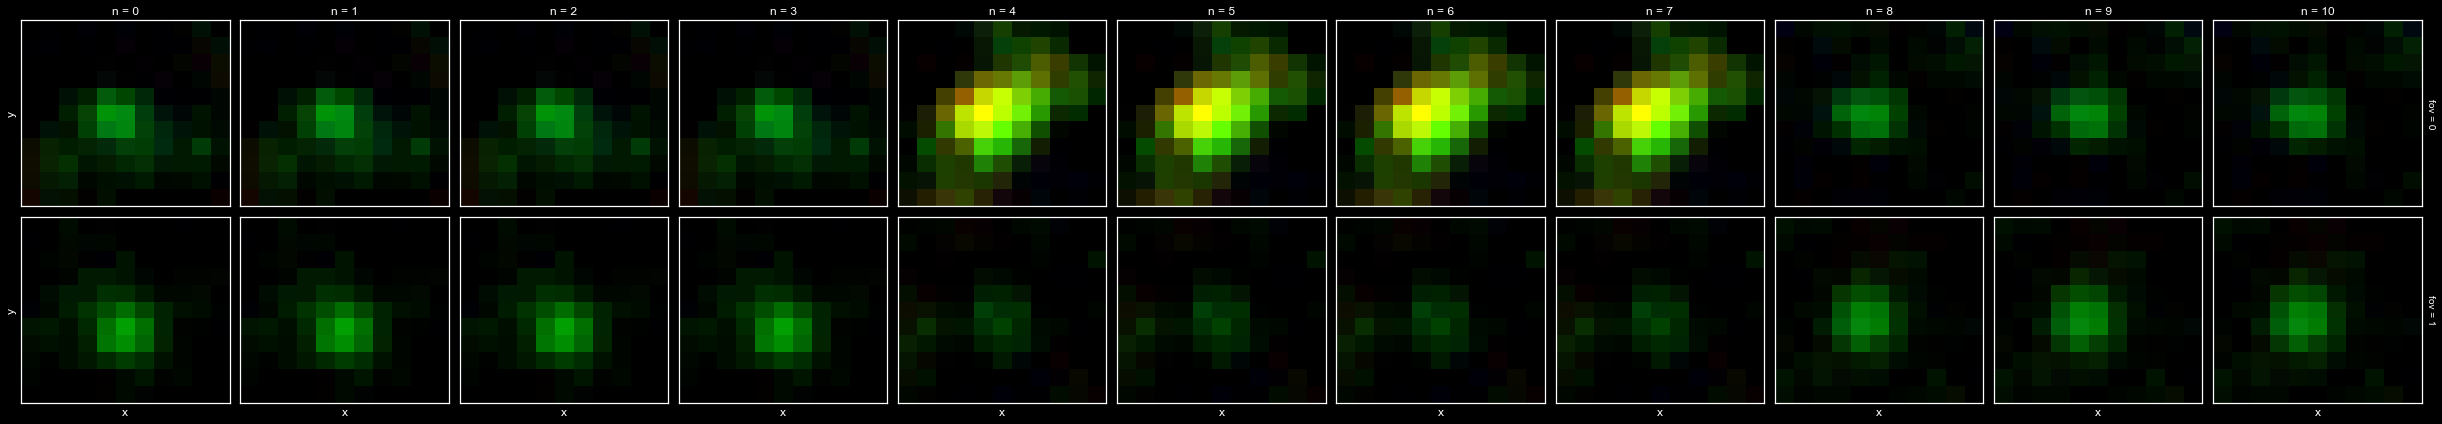

In [249]:
# Repeat measurement above, but looking at background-subtracted image instead of standard max-projection
# You can see a big improvement in signal, by taking the best plane... Can get slighly better with roll_n = 1 above, but more noisy?
best_z_bg.sel(ch=[1,2,3],n=slice(0,10)).mean(dim=['t']).plot.imshow(col='n',row='fov',rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0, vmax=30000)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


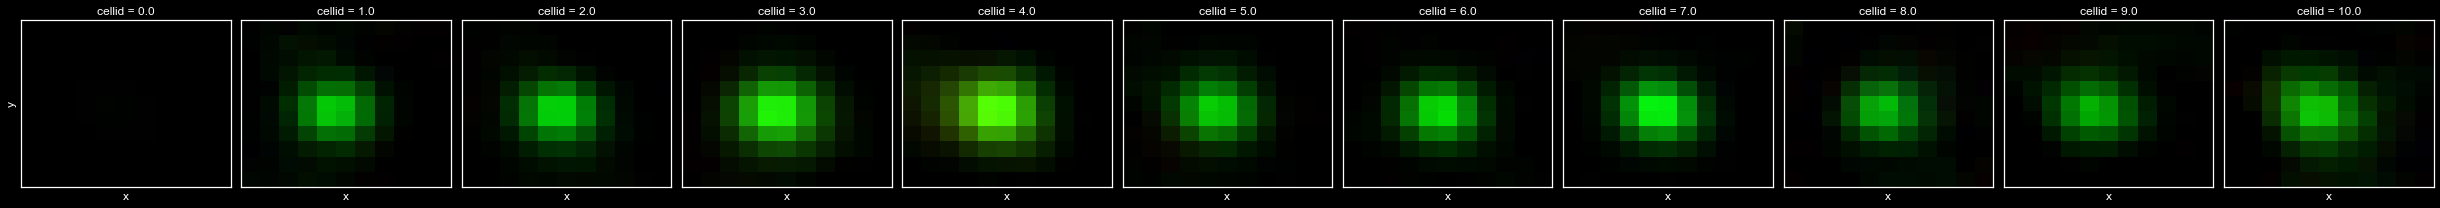

In [280]:
# Let's compare the average spot from different cells 
# Repeat measurement above, but looking at background-subtracted image instead of standard max-projection
# You can see a big improvement in signal, by taking the best plane... Can get slighly better with roll_n = 1 above, but more noisy?
cell_ids= np.unique(my_ca.cellid)
cells = xr.concat([best_z_bg.where(my_ca.cellid==i) for i in cell_ids],dim=pd.Index(cell_ids, name='cellid')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='cellid', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


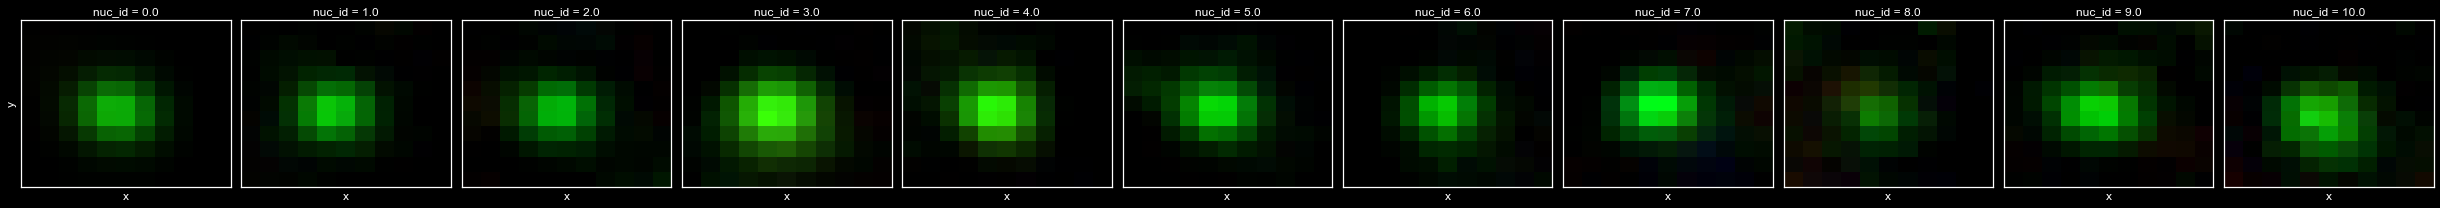

In [299]:
# Now let's look at the spots in/over the nucleus:
my_ids= np.unique(my_ca.nucid)
cells = xr.concat([best_z_bg.where(my_ca.nucid==i) for i in my_ids],dim=pd.Index(my_ids, name='nuc_id')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='nuc_id', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)

C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1344: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(x.dtype, str):
C:\Users\tim_s\Anaconda3\lib\site-packages\xarray\plot\plot.py:1395: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if np.issubdtype(v.dtype, str):


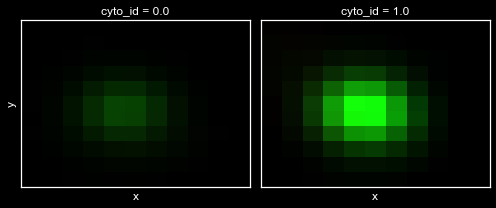

In [298]:
# Now let's look at the spots in/over the cytoplasm: can tell translation signal is way higher:
my_ids= np.unique(my_ca.cytoid)
cells = xr.concat([best_z_bg.where(my_ca.cytoid==i) for i in my_ids],dim=pd.Index(my_ids, name='cyto_id')).to_dataset()
cells.int.sel(ch=[1,2,3]).mean(dim=['t','n','fov']).plot.imshow(col='cyto_id', rgb='ch',cmap='gray',xticks=[],yticks=[],vmin=0,vmax=30000)